In [2]:
import os
import pytimber
import dill
import pickle
from collections import defaultdict
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import norm
from scipy.special import erf
from pylab import contour
import scipy.ndimage as ndi
import matplotlib.ticker as tck
from matplotlib.pylab import rcParams

class Mat:
    """Dictionary of material properties"""
    def __init__(self):
        """Initialise and add parameters to class"""
        self.material = {}    
        #                              A    L_N     L_r     ProbE  L_i
        self.material.update({'Be': [  9.0, 0.2993, 0.3528, 0.289, 0.4210]})
        self.material.update({'C':  [ 12.0, 0.2960, 0.2140, 0.310, 0.4290]})
        self.material.update({'Al': [ 27.0, 0.2582, 0.0890, 0.350, 0.3970]})
        self.material.update({'Si': [ 28.1, 0.3016, 0.0937, 0.352, 0.4652]})
        self.material.update({'Ti': [ 47.9, 0.1740, 0.0356, 0.375, 0.2780]})
        self.material.update({'Fe': [ 55.8, 0.1037, 0.0172, 0.382, 0.1677]})
        self.material.update({'Cu': [ 63.5, 0.0939, 0.0144, 0.387, 0.1532]})
        self.material.update({'Mo': [ 96.0, 0.0910, 0.0096, 0.403, 0.1525]})
        self.material.update({'Sn': [118.7, 0.1344, 0.0121, 0.411, 0.2280]})
        self.material.update({'Ta': [180.9, 0.0660, 0.0041, 0.425, 0.1147]})
        self.material.update({'WRe':[184.4, 0.0560, 0.0035, 0.412, 0.0952]})
        #
        for index, entry in self.material.items():
            setattr(self, index, entry)
            
    def GetMaterial(self,index):
        return(self.material[index])
               
    def GetKeys(self):
        return(list(self.material.keys()))

    
class Acc:
    """Dictionary of accelerator parameters"""
    def __init__(self):
        """Initialise and add parameters to class"""
        self.accelerator = {}    
        self.accelerator.update({'SPS': {
            "desc": 'SPS',
            "phi": 70./180.*np.pi, 
            "dmu": 4./180.*np.pi,
            "betxs": 94.,
            "betxd": 94.,
            "betn" : 94.,
            "wd" : 0.25,
            "ws" : 0.50,
            "xoff" : 0.0,
            "p": 400.,
            "Aper" : 18.5,
            "sigpx" : 12.,
            "L": 2.42,
            "nsig": 5,}})
        self.accelerator.update({'JPARC5deg':  {
            "desc": 'JPARC 5 deg',
            "phi": 70./180.*np.pi, 
            "dmu": 5./180.*np.pi,
            "betxs": 38.9,
            "betxd": 28.0,
            "betn" : 38.9,
            "wd" : 0.24,
            "ws" : 0.08,
            "xoff" : 0.0,
            "p": 30.,
            "Aper" : 18.5,
            "sigpx" : 17.,
            "L": 3.2,
            "nsig": 5,}})
        self.accelerator.update({'JPARC04deg': {
            "desc": 'JPARC 0.4 deg',
            "phi": 70./180.*np.pi, 
            "dmu": 0.378/180.*np.pi,
            "betxs": 38.9,
            "betxd": 38.9,
            "betn" : 38.9,
            "wd" : 0.08,
            "ws" : 0.08,
            "xoff" : 0.0,
            "p": 30.,
            "Aper" : 18.5,
            "sigpx" : 17.,
            "L": 3.2,
            "nsig": 5,}}) 
        #
        for k, v in self.accelerator.items():
            setattr(self, k, v)
               
    def GetAccelerator(self,index):
        return(self.accelerator[index])
               
    def GetKeys(self):
        return(list(self.accelerator.keys()))

class DiffuserLoss:
    """
    Class to calculate overall losses for diffuser and septum
    :param mat: object containing MATERIAL parameters like scattering lengths, Z
    :param acc: object containg ACCELERATOR parameters like beta, diffuser width 
    :
    :returns: component and total loss values
    :
    :method SetParameter: set a specific parameter
    :method CalculateLoss: perform loss calculation (also done with defaults on __init__)
    :
    :example 

       m = Mat()
       a = Acc()
       L = Loss(m.Ta,a.SPS)
       L.SetParameter('wd',0.15)
       myloss.CalcLoss()
       print('Total loss fraction {:.4f}'.format(L.loss_t/L.loss_0))
       
    """
    def __init__(self,mat,acc):
        """Initialise and perform Calulation"""
        self.mat = mat
        self.acc = acc
        self.InitParameters(acc)
        self.InitMaterials(mat)
        self.CalculateLoss()
            
    def InitParameters(self,acc):
        """Initialise parameters for the chosen accelerator"""
        self.desc = acc['desc']
        self.phi = acc['phi']
        self.dmu = acc['dmu']
        self.betxs = acc['betxs']
        self.betxd = acc['betxd']
        self.betn = acc['betn']
        self.wd = acc['wd']
        self.ws = acc['ws']
        self.xoff = acc['xoff']
        self.p = acc['p']
        self.Aper = acc['Aper']
        self.sigpx = acc['sigpx']
        self.L = acc['L']
        self.nsig = acc['nsig']
        
    def InitMaterials(self,mat):
        """Initialise parameters for the chosen material"""
        self.A = mat[0]
        self.Ln = 1000*mat[1]
        self.Lr = 1000*mat[2]
        self.Pe = mat[3]
        self.Li = 1000*mat[4]
        self.Le = self.Li*self.Ln/(self.Li-self.Ln)
        return(self.A,self.Ln,self.Li,self.Lr,self.Le,self.Pe)
        
    def SetParameter(self,param,val):
        """Update value of a single parameter"""
        setattr(self, param, val)
        
    def NormalisedParameters(self):
        """Calculate the normalised parameters"""
        self.wdn = self.wd * (self.betn/self.betxd)**0.5                  # Normalised diffuser width
        self.wsn = self.ws * (self.betn/self.betxs)**0.5                  # Normalised septum width
        self.wdsn = self.wdn * np.sin(self.phi)/np.sin(self.phi-self.dmu) # Normalised diffuser width at septum
        self.xoffn = self.xoff * (self.betn/self.betxd)**0.5              # normamlised diffuser offset
        return(self.wdn,self.wsn,self.wdsn,self.xoffn)
    
    def ScatteringProcessNumbers(self):
        """Calculate the populations for the different scattering processes"""
        self.ampD = 1/np.sin(self.phi-self.dmu)                           # line density of the beam at the diffuser
        self.ampS = 1/np.sin(self.phi)                                    # line density of the beam at the ES
        self.fmc = np.exp(-self.L/self.Li)*np.exp(-self.L/self.Le)        # fraction with only MC scatter
        self.fe  = np.exp(-self.L/self.Li)*(1-np.exp(-self.L/self.Le))    # fraction with elastic and mc scatter
        self.fni = np.exp(-self.L/self.Li)                                # fraction not interacing inelastically 
        self.fi  = 1-self.fni                                             # fraction with only inelastic scatter
        self.nd = self.wdn * self.ampD                                    # number impacting diffuser
        self.ns = self.ws * self.ampS                                     # number impacting septum without diffuser
        self.ne = self.wdn * self.ampD * self.fe                          # number elastically scattered
        self.dmc = self.ampD * self.fmc                                   # density undergoing MC scatter                       
        self.de = self.ampD * self.fe                                     # density undergoing e scatter 
        self.ni = self.ampD * self.fi * self.nd                           # number undergoing i scatter 
        self.n0s = (self.fe+self.fmc)*self.ns
        return(self.nd,self.ns,self.ne,self.dmc,self.de,self.ni,self.fe,self.fmc,self.fi,self.fni,self.n0s)
    
    def SigmaMC(self):
        """Calculate the MC scattering angle"""
        self.sigmc = (self.betn*self.betxd)**0.5*13.6/self.p*(self.L/self.Lr)**0.5*(1+0.038*np.log(self.L/self.Lr))
        return(self.sigmc)
 
    def SigmaE(self):
        """Calculate the elastic scattering angle"""
        self.sige = (self.betn*self.betxd)**0.5*197/(self.p*self.A**(1/3))
        return(self.sige)
    
    def ScatteredBeamSizes(self):
        """Calculate the scattered beam sizes at the ES"""
        self.sigpxn = self.sigpx/1000*(self.betn*self.betxd)**0.5
        self.signpx = self.nsig*self.sigpxn
        self.xsmc = (self.sigpxn**2+self.sigmc**2)**0.5*np.sin(self.dmu)
        self.xse = (self.sigpxn**2+self.sige**2)**0.5*np.sin(self.dmu)
        return(self.xsmc,self.xse,self.signpx)
    
    def LossForScatteredParticles(self,sig,amp):
        """Calculate the loss on the ES from the scattered distribution"""
        x1 = (self.xoffn + (self.ws+self.wdsn)/2)/(2*sig**2)**0.5
        x2 = (self.xoffn + (self.ws-self.wdsn)/2)/(2*sig**2)**0.5
        x3 = (self.xoffn - (self.ws-self.wdsn)/2)/(2*sig**2)**0.5
        x4 = (self.xoffn - (self.ws+self.wdsn)/2)/(2*sig**2)**0.5
        retval = amp*sig/2**0.5*((self.IntegralERF(x1)-self.IntegralERF(x2))-(self.IntegralERF(x3)-self.IntegralERF(x4)))
        return(retval)
    
    def IntegralERF(self,z):
        """Calculate the integrate of ERF(z)"""
        retval = z*erf(z) + np.exp(-(z**2))/np.pi**0.5
        return(retval)
    
    def IntegratedUnscatteredParticleDensityFunction(self,p,x):
        """Calculate the integrated density funciton of the unscattered particles"""
        c = self.ampS
        a = (self.wdsn+x)/2
        lossL = min(0.5*c/x*(max( p-(a-x),0))**2,0.5*c*x)+c*max( p-a,0)
        lossR = min(0.5*c/x*(max(-p-(a-x),0))**2,0.5*c*x)+c*max(-p-a,0)
        return(lossL, lossR)
    
    def UnscatteredParticleLoss(self):
        """Calculate the contribution from the unscattered particles"""
        x1 = self.signpx * np.sin(self.dmu)
        p1 = self.xoffn + self.wsn/2
        p2 = self.xoffn - self.wsn/2
        L1 = self.IntegratedUnscatteredParticleDensityFunction(p1,x1)
        L2 = self.IntegratedUnscatteredParticleDensityFunction(p2,x1)
        retval = (L1[0]-L2[0])+(L2[1]-L1[1])
        return(retval)
    
    def CalculateLoss(self):
        """Calculate the loss contributions and the total"""
        self.NormalisedParameters()
        self.ScatteringProcessNumbers()
        self.SigmaMC()
        self.SigmaE()
        self.ScatteredBeamSizes()
        self.loss_0  = self.ns
        self.loss_d  = self.ni
        self.loss_a  = self.ne*(1-erf(self.Aper/((self.sigmc**2 + self.sige**2)**0.5*(2*2**0.5))))
        self.loss_mc = self.LossForScatteredParticles(self.xsmc,self.dmc)
        self.loss_e  = self.LossForScatteredParticles(self.xse,self.de)
        self.loss_u  = self.UnscatteredParticleLoss()
        self.loss_t  = (self.loss_d + self.loss_mc + self.loss_e + self.loss_a + self.loss_u)
        return(self.loss_d, self.loss_mc, self.loss_e, self.loss_a, self.loss_u, self.loss_0, self.loss_t)



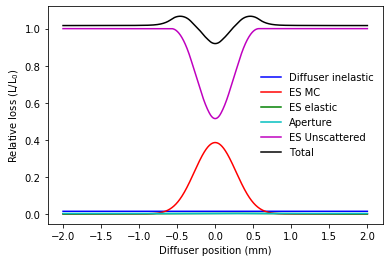

In [9]:
# plots components of total loss for different diffuser positions

samples = 2000
X = np.linspace(-2,2,samples)
results = np.zeros((samples,7))

m = Mat().WRe
a = Acc().SPS
L = DiffuserLoss(m,a)

for j, x in enumerate(X):
    L.SetParameter('xoff',x)
    myLoss = L.CalculateLoss()
    results[j,:] = myLoss/L.loss_0
    
fig, ax = plt.subplots()
plt.plot(X,results[:,0],'b',label='Diffuser inelastic')
plt.plot(X,results[:,1],'r',label='ES MC')
plt.plot(X,results[:,2],'g',label='ES elastic')
plt.plot(X,results[:,3],'c',label='Aperture')
plt.plot(X,results[:,4],'m',label='ES Unscattered')
plt.plot(X,results[:,6],'k',label='Total')
plt.ylabel('Relative loss (L/L$_0$)')
plt.xlabel('Diffuser position (mm)')
plt.legend(frameon=False)
plt.show()

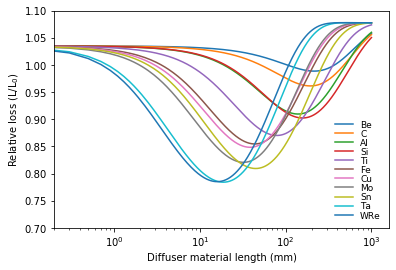

In [6]:
# plots total loss as a function of length for different materials

samples = 5000
Length = np.linspace(0.1,1000,samples)
result = np.zeros((samples))

a = Acc().SPS
mat = Mat()
K = mat.GetKeys()
Loss = DiffuserLoss(mat.GetMaterial(K[0]),a)

fig, ax = plt.subplots()

for i,k in enumerate(K):
    Loss = DiffuserLoss(mat.GetMaterial(k),a)
    for j, L in enumerate(Length):
        Loss.SetParameter('L',L)
        Loss.CalculateLoss()
        result[j] = Loss.loss_t/Loss.loss_0
    plt.plot(Length,result,label=k)

plt.xlabel('Diffuser material length (mm)')
plt.ylabel('Relative loss (L/L$_0$)')
plt.xscale('log')
plt.legend(frameon=False, labelspacing=0.01, fontsize=9,loc='lower right')
plt.ylim(0.7,1.1)
plt.xlim(0.2,1600)
plt.show()

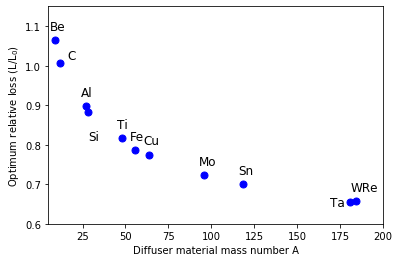

In [10]:
# plots best loss as a function of material

samples = 1000
Length = np.linspace(0.1,1000,samples)
result = np.zeros((samples))

a = Acc().SPS
mat = Mat()
K = mat.GetKeys()
Loss = DiffuserLoss(mat.GetMaterial(K[0]),a)

fig, ax = plt.subplots()

Lmin = np.zeros((len(K),2))

for i,k in enumerate(K):
    Loss = DiffuserLoss(mat.GetMaterial(k),a)
    Loss.SetParameter('nsig',4)
    Loss.SetParameter('ws',0.2)
    Lmin[i,0] = Loss.A
    for j, L in enumerate(Length):
        Loss.SetParameter('L',L)
        Loss.CalculateLoss()
        result[j] = Loss.loss_t/Loss.loss_0
    Lmin[i,1] = result[np.argmin(result)]
    if K[i] == 'Si':
        plt.text(Lmin[i,0], Lmin[i,1]-0.07, K[i], fontsize=12)
    elif K[i] == 'Ta':
        plt.text(Lmin[i,0]-12, Lmin[i,1]-0.01, K[i], fontsize=12)
    elif K[i] == 'C':
        plt.text(Lmin[i,0]+4, Lmin[i,1]+0.01, K[i], fontsize=12)
    else:
        plt.text(Lmin[i,0]-3, Lmin[i,1]+0.025, K[i], fontsize=12)

plt.plot(Lmin[:,0],Lmin[:,1],'bo',markersize=7)
plt.xlabel('Diffuser material mass number A')
plt.ylabel('Optimum relative loss (L/L$_0$)')
plt.ylim(0.6,1.15)
plt.xlim(5,200)
plt.show()

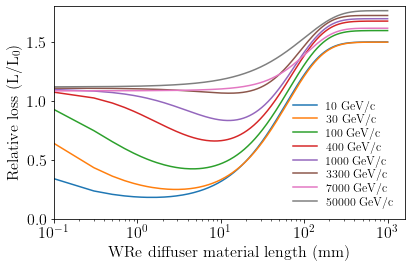

In [12]:
# plots loss as a function of length for different energies

import matplotlib.ticker as tck
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

ENERGY = [10, 30, 100, 400, 1000, 3300, 7000, 50000]
BETA = [30, 35, 60, 95, 120, 160, 160, 350]
SIG = [20, 17, 15, 12, 10, 8, 6, 4]

samples = 5000
Length = np.linspace(0.1,1000,samples)
result = np.zeros((samples))

a = Acc().SPS
m = Mat().WRe
Loss = DiffuserLoss(m,a)

fig, ax = plt.subplots()

for i,e in enumerate(ENERGY):
    Loss.SetParameter('nsig',4)
    Loss.SetParameter('betxd',BETA[i])
    Loss.SetParameter('betxs',BETA[i])
    Loss.SetParameter('betn',BETA[i])
    Loss.SetParameter('Aper',18.5*(e/400)**(-1/3))
    Loss.SetParameter('sigpx',SIG[i])
    Loss.SetParameter('ws',0.2)
    Loss.SetParameter('wd',0.25)
    Loss.SetParameter('p',e)
    Loss.SetParameter('addSigQuad',1.0)
    ## add
    for j, L in enumerate(Length):
        Loss.SetParameter('L',L)
        Loss.CalculateLoss()
        result[j] = Loss.loss_t/Loss.loss_0
    plt.plot(Length,result,label=str(e) + ' GeV/c')
    
plt.xlabel('WRe diffuser material length (mm)')
plt.ylabel('Relative loss (L/L$_0$)')
plt.xscale('log')
plt.legend(frameon=False, labelspacing=0.06, fontsize=12,loc='lower right')
plt.ylim(0.0,1.8)
plt.xlim(0.1,1600)
plt.show()

### Analytical expressions for the losses on an ES and diffuser 

Normalisation of positions and angles are made to ease some of the transformations. For the normalisation, $x = \overline{x} \sqrt{\beta_N/\beta_x}$, and $px = \overline{x} \sqrt{\frac{\beta_N}{\beta_x}}\alpha_x + \overline{px} \sqrt{\beta_N\beta_x}$, where $\overline{}, \overline{px}$ are the un-normalised values. The factor $\beta_N = 94\text{ m}$ (the beta function at the ES septum entrance) is used to give normalised values in (normalised) $\text{mm}$ or $\text{mrad}$ at the SPS ES which are equal to real mm offsets.

For *changes* in angle $\delta{\theta}$ at constant x, e.g. through scattering, the angle normalisation reduces to $\delta{\theta} = \delta\overline{\theta}\sqrt{\beta_N \beta_x}$.

For a separatrix angle at the septum of $\phi_{s}$, with phase advance $\delta\mu$ between diffuser and septum, the separatrix angle at the diffuser is $\phi_{d} = \phi_{s} - \delta\mu$. The particle density is assumed uniform along the separatrix. The ES is assumed to be a black-box absorber, such that all impacts result in the particle being lost.

#### Losses on ES without diffuser
Under these assumptions an ES of width $w_s$ intercepts and loses  a number of particles $N_{s0} = L_{s0} = \frac{w_s}{\sin\phi_s}$ - which is the reference for nornalising all subsequent losses. Expanding to real coordinates:

\begin{equation*}
L_{s0} = \frac{\overline{w}_s\sqrt{\beta_N/\beta_s}}{\sin\phi_s}
\label{eq:01}  \tag{1}
\end{equation*}

#### Losses on diffuser
An upstream diffuser intercepts a number of particles $N_d = \frac{w_d}{\sin(\phi_s - \delta\mu)}$. However, for a diffuser of length $l_d$ only a fraction $F_i = \left[1-\exp(-l_d/\lambda_i)\right]$ are directly lost as a result of ineleastic scattering. The direct absolute loss at the diffuser is then $L_d = N_d  F_i$. This can be expanded as:

\begin{equation*}
L_d = N_d F_i = \frac{w_d}{\sin(\phi_s - \delta\mu)}\left[1-\exp(-l_d/\lambda_i)\right]
\label{eq:02}  \tag{2}
\end{equation*}

#### Scattering through diffuser
The surviving particles will have a distribution of angles given by their initial distribution (the angular width of the separatrix) and the scattering processes undergone. These are Multiple-Coulomb and Elastic Nuclear, characterised by the RMS scattering angle *projected into one transverse plane* of $\theta_{MC}$ and $\theta_e$ respectively. From the literature one can readily find the expressions for these RMS angles - for a material with radiation length $X_0$ and a beam momentum $p$, after normalisation the MC scattering RMS angle can be written as:

\begin{equation*}
\overline{\theta}_{MC}\approx \sqrt{\beta_N \beta_d}\frac{13.6}{p \beta_{r}}\sqrt{\frac{l_d}{X_{0}}} 
\left(1 + 0.038 \text{ ln}\frac{l_d}{X_{0}}\right)~
\text{mrad}
\label{eq:03} \tag{3}
\end{equation*}

The normalised RMS elastic scattering angle depends on the material Mass number $A$ as well as the beam momentum $p$, and is described by:

\begin{equation*}
\overline{\theta}_{e} \approx \sqrt{\beta_N \beta_d} \frac{197 }{A^{1/3} p}~\text{mrad}
\label{eq:04} \tag{4}
\end{equation*}

The absolute number of scattered (MC and elastic) particles which exit the diffuser is just $N_d (1 - F_i) = N_d \exp(-l_d/\lambda_i)$. Of these, a fraction $F_e = \left[1-\exp(-l_d/\lambda_e)\right]$ will have undergone elastic scattering in addition to MC scattering, while the remaining fraction $1 - F_e = exp(-l_d/\lambda_e)$ are only subject to MC scattering. 

This allows to write down the absolute numbers of particles $N_{MC}$ undergoing MC scattering alone, and the number $N_e$ which have also been elastically scattered, as:

\begin{equation*}
N_{MC} = \frac{w_d}{\sin\phi_d} \exp(-l_d/\lambda_i)\exp(-l_d/\lambda_e) 
= \frac{w_d}{\sin(\phi_s - \delta\mu)} \exp\left[-\frac{l_d(\lambda_i+\lambda_e)}{\lambda_i\lambda_e}\right]
\label{eq:05} \tag{5}
\end{equation*}

\begin{equation*}
N_{e} = \frac{w_d}{\sin(\phi_s - \delta\mu)} \left[1-\exp(-l_d/\lambda_e)\right]\exp(-l_d/\lambda_i)
\label{eq:06} \tag{6}
\end{equation*}

#### Losses on aperture
To account for the fact that some of the elastically scattered particles have very big angles and will be lost locally or in the subsequent transfer or machine turn, an aperture limit is defined by the machine acceptance $A$. This is somewhat complicated to evaluate since both planes should be taken into account, which have different acceptances and also different betas at the diffuser - an approximation is made here by using the minimum of the H and V acceptances at the H and V beta location. For a normalised acceptance $A \text{ mm.mrad}$ a particle scattered by a normalised angle $\theta$ will be lost if $\theta > A$. If we consider that the SPS aperture/TL aperture is about $\pm$20~mm at a location with beta function $\beta$ of 109~m, this gives an acceptance of about $18.5\text{ mrad}$ in angle, which is pessimistic. 

The aperture losses $L_a$ are defined as any particles scattered with an angle larger than this limit $A$, i.e. 

\begin{equation*}
L_a = \frac{N_e}{\sigma}{\sqrt{2\pi}} \int_{A}^{-A}
\exp{\left[ -\left( \frac{x}{2\sigma} \right)^2 \right]} dx
= N_e \left[1-
\text{erf} \left( \frac{A}{\sigma\sqrt{2}} \right)
\right]
\label{eq:9}  \tag{9}
\end{equation*}

where $\sigma = \sqrt{\theta_e^2 + \theta_{MC}^2}$

#### Spread at ES from diffuser scattering
The key part of the diffuser performance is that the rotation by phase advance $\delta\mu$ to the diffuser of the scattered distributions initially of width $w_d$ and angular spreads $\theta_{e}$ and $\theta_{MC}$ produces new distributions in $x$ which only the cetral part intersects the ES, and the larger scattered ampitudes miss. The positional spread in the scattering terms are just the rotation of the scattering angle to the ES location through the phase advance $\delta\mu$:

\begin{equation*}
\sigma_{xMC} = \theta_{MC} \sin{\delta\mu} 
\label{eq:07} \tag{7}
\end{equation*}

\begin{equation*}
\sigma_{xe} = \sqrt{\theta_e^2 + \theta_{MC}^2} \sin{\delta\mu} 
\label{eq:08} \tag{8}
\end{equation*}

#### Losses on ES
The losses at the ES can be spilit into three parts: $L_{MC}$ from the MC scattered particles from the diffuser, $L_e$ from the elastically scattered particles, and (very importantly) $L_U$ from the unscattered edges of the separatrix either due to a diffuser misalignment or width mismatch (or as we shall see in an extension of the treatment, to the finite angular spread of the separatrix).

The losses from the scattered distributions can both be treated the same way: in the following the subscripts $_{MC}$ and $_e$ are dropped until the final expressions.

##### Losses on ES from scattered distributions

The scattered distribution is transported to the ES with a convolution of the uniform (diffuser width) and Gaussian (scattering) distributions. 

In general, the probility density function $p(t)$ for the convolution of a uniform distribution of unity height between $a < b$ with a Gaussian of mean $\mu$ and sigma $\sigma$ at a location x is given by:

\begin{equation*}
p(x) = \frac{1}{(b-a)\sqrt{2\pi\sigma^2}}\int_{b+\mu}^{a+\mu}\exp\left(-\frac{(\tau-x)^2}{2\sigma^2}\right) d\tau 
= \frac{1}{2(b-a)} \left[ \text{erf}\left( \tfrac{x-(\mu+a)}{\sqrt{2\sigma^2}} \right) - \text{erf}\left( \tfrac{x-(\mu+b)}{\sqrt{2\sigma^2}} \right)\right]
\label{eq:10}  \tag{10}
\end{equation*}

For the width in position from the diffuser at the ES given by $w_{dsn}$, with $\mu = 0$ and the scattering distribution in $x_{\sigma_x}$ at the ES given by $\sigma_{x} = \delta\sigma_d \sin\delta\mu$, we find for the PDF at the ES:

\begin{equation*}
p(x) = \frac{1}{2 w_{dn}} \left[ \text{erf}\left( \tfrac{x+w_{dsn}/2}{\sqrt{2\sigma_{xES}^2}} \right) - \text{erf}\left( \tfrac{x-w_{dsn}/2}{\sqrt{2\sigma_{xES}^2}} \right)\right]
\label{eq:11}  \tag{11}
\end{equation*}

From the PDF we can express the losses $L_{MC}$ or $L_e$ on an ES with width $w_{sn}$ and offset $x_{o}$:

\begin{equation*}
L = \int_{x_{o}-\frac{w_{sn}}{2}}^{x_{o}+\frac{w_{sn}}{2}} p(x)dx = \frac{1}{2 w_{dn}} \int_{x_{o}-\frac{w_{sn}}{2}}^{x_{o}+\frac{w_{sn}}{2}}
\left[ \text{erf}\left( \tfrac{x+\frac{w_{dsn}}{2}}{\sqrt{2\sigma_{xES}^2}} \right) - \text{erf}\left( \tfrac{x-\frac{w_{dsn}}{2}}{\sqrt{2\sigma_{xES}^2}} \right)\right]
\label{eq:12}  \tag{12}
\end{equation*}

Since $\int_{}^{}\text{erf}(z)dz = z\text{ erf}(z)+\frac{e^{-z^2}}{\sqrt{\pi}}$, we can now write the full expression for the loss as:

\begin{equation*}
L = \frac{n}{2 w_{dn}} \left[ 
\mathcal{F}\left( \frac{x_1}{2\sigma\sqrt{2}}\right) - 
\mathcal{F}\left( \frac{x_2}{2\sigma\sqrt{2}}\right) - 
\mathcal{F}\left( \frac{x_3}{2\sigma\sqrt{2}}\right) + 
\mathcal{F}\left( \frac{x_4}{2\sigma\sqrt{2}}\right)
\right]
\label{eq:13}  \tag{13}
\end{equation*}

where $\mathcal{F}(z) = z\text{ erf}(z)+\frac{e^{-z^2}}{\sqrt{\pi}}$ and the horizontal coordinates $x_1 - x_4$ are given by:

$x_1 = 2x_{off} + \frac{w_s + w_{ds}}{2}$

$x_2 = 2x_{off} + \frac{w_s - w_{ds}}{2}$

$x_3 = 2x_{off} - \frac{w_s - w_{ds}}{2}$

$x_4 = 2x_{off} - \frac{w_s + w_{ds}}{2}$

The two contributions from MC and elastic scattered particles are obtained by using the specific values for $n_{MC}, n_e$ and $\sigma_{xMC}, \sigma_{xe}$ in equation \ref{eq:13}.


##### Losses on ES from unscattered particles
The final part of the losses at the ES are from particles which are not scattered on the diffuser. This is defined by the separatrix angular distribution (width), the gap cut by the diffuser and the phase advance between diffuser and septum. 

#### Total Losses
The total losses on the diffuser, aperture and the septum are then simply the sum of the separate components:

\begin{equation*}
L_{Tot} = L_d + L_e + L_{MC} + L_U + L_a
\label{eq:17}  \tag{17}
\end{equation*}

